# The evolution of trust and trustworthiness
## By Alex MARCELINO SANTEE, Jean-Nicolas GREGOIRE, Sacha TESTAERT

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Union, List
from scipy.integrate import odeint
import seaborn as sns

In [22]:
import egttools as egt
from egttools.games import AbstractNPlayerGame
from egttools import sample_simplex
from egttools.analytical import PairwiseComparison
from egttools.utils import calculate_stationary_distribution
from egttools.plotting import draw_invasion_diagram

In [23]:
class GameMatrix(AbstractNPlayerGame):
    def __init__(self, trustGameMatrix, r, x):
        r, #
        x,



[[0.6  0.9  0.99 0.9 ]
 [0.21 0.6  0.99 0.9 ]
 [0.   0.   0.5  1.  ]
 [0.   0.   0.   0.5 ]]


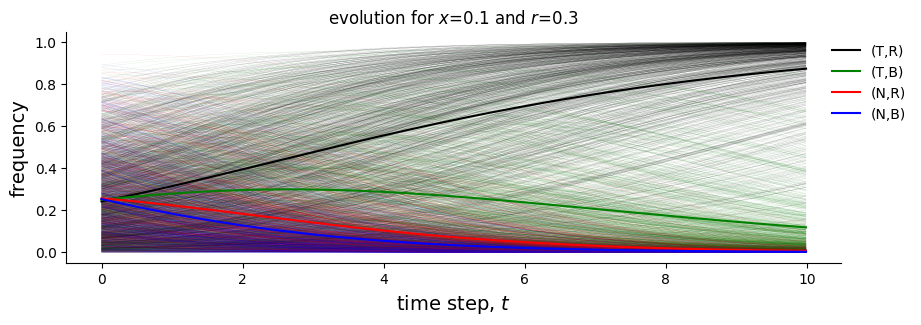

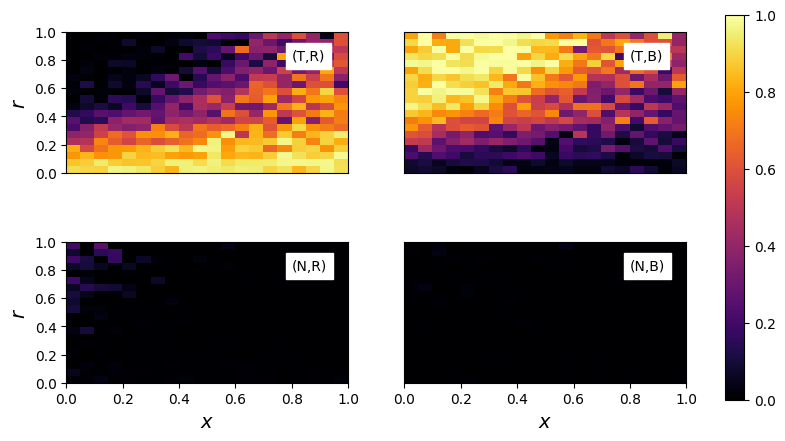

In [24]:
# Single game (Trust game, binary decision)
# A receives R = 1 - x + 3xr, can Trust (T) or not (N)
# B receives R = 3x(1-r), can Reciprocate (R) or Betray (B)
# Strategies are a combination of A,B (T,R), (T,B), (N,R), (N,B)
nb_strategies = 4


def gen_trust_matrix(x=1, r=0.5):
    # Trust Game Matrix
    #   R B
    # T
    # N
    matrix = np.array([
        [[1-x+3*r*x, 3*x*(1-r)], [1-x, 3*x]],
        [[1, 0], [1, 0]],
    ])
    return matrix


def gen_strategies_matrix(x=1, r=0.5):
    # Strategies are (T,R), (T,B), (N,R), (N,B)
    # A\B  (TR) (TB) (NR) (NB)
    # (TR)
    # (TB)
    # (NR)
    # (NB)
    # Averaging the results for main diagonal (or we cant use egttools)
    base = gen_trust_matrix(x, r)
    matrix = np.empty((4, 4))
    # using bit 1 is T/N, bit 0 is R/B
    for i in range(4):
        for j in range(4):
            if i < j:  # over main diagonal is A reward
                matrix[i, j] = base[i // 2, j % 2, 0]
            elif i > j:  # below main diagonal is B reward
                matrix[i, j] = base[i // 2, j % 2, 1]
            else:  # i==j
                matrix[i, j] = np.sum(base[i // 2, j % 2])/2
    return matrix


# Simulation
# Copy of other players actions with probability from eq. 2.1
# number of MC steps equals to population size N=500
# Initializes each player randomly
# consists in chosing two players P1, P2 and playing the game w/ 4 neighbors

x, r = (0.1, 0.3)
game_matrix = gen_strategies_matrix(x, r)
print(game_matrix)
# game = Matrix2PlayerGameHolder(4, game_matrix)

nb_runs = 1000
nb_time_steps = 1000
t = np.arange(0, 10, 10/nb_time_steps)


def run_replicator_dynamics(
        t: np.ndarray,
        payoff_matrix: np.ndarray,
        nb_runs: int,
        initial_state=None,
        ):

    results = []
    for i in range(nb_runs):
        if initial_state is None:
            x0 = egt.sample_unit_simplex(nb_strategies)
        else:
            assert 0.999 < np.sum(initial_state) < 1.001
            x0 = initial_state
        result = odeint(
                lambda x, t:
                egt.analytical.replicator_equation(x, payoff_matrix),
                x0, t)
        results.append(result)

    return results


results = run_replicator_dynamics(t, game_matrix, nb_runs)
results = np.asarray(results)


# Multiple network types - pair are generated from connected nodes
# well-mixed, lattice (triangle, square, hexagon), random and scale-free
# heterogeneous networks can consider different degree (normalized) or not
# unnormalized scale-free network is the only to evolve trust

# Types of plot:
# 1. Proportion of population sweeping through x and r
# 2. Evolution Through time given x and r

# Plot for population evolution
colors = ["black", "green", "red", "blue"]
strategy_labels = ["(T,R)", "(T,B)", "(N,R)", "(N,B)"]
fig, ax = plt.subplots(figsize=(10, 3))

for run in results:
    for i in range(nb_strategies):
        ax.plot(t, run[:, i],
                linewidth=.05, alpha=0.6, color=colors[i])

for i in range(nb_strategies):
    ax.plot(t, np.mean(results[:, :, i], axis=0), linewidth=1.5,
            alpha=1, color=colors[i], label=strategy_labels[i])

ax.set_title(f"evolution for $x$={x} and $r$={r}")
ax.legend(frameon=False, bbox_to_anchor=(1.1, 1, 0, 0), loc='upper right')
ax.set_ylabel("frequency", fontsize=14)
ax.set_xlabel("time step, $t$", fontsize=14)
# ax.set_ylim(-0.2, 1.2)
sns.despine()
plt.show()

# Sweep plot
xs = np.linspace(0, 1, 20)
rs = np.linspace(0, 1, 20)
nb_runs = 10  # 1000
nb_time_steps = 1000
t = np.arange(0, 10, 10/nb_time_steps)


def plot_heatmaps(avg_results):
    fig, axs = plt.subplots(figsize=(10, 5), ncols=2, nrows=2)

    im = axs[0, 0].imshow(avg_results[:, :, 0], cmap="inferno", vmin=0.0, vmax=1.0,
                     origin="lower", extent=[0, 1, 0, 1], aspect=0.5,)
    axs[0, 1].imshow(avg_results[:, :, 1], cmap="inferno", vmin=0.0, vmax=1.0,
                     origin="lower", extent=[0, 1, 0, 1], aspect=0.5,)
    axs[1, 0].imshow(avg_results[:, :, 2], cmap="inferno", vmin=0.0, vmax=1.0,
                     origin="lower", extent=[0, 1, 0, 1], aspect=0.5,)
    axs[1, 1].imshow(avg_results[:, :, 3], cmap="inferno", vmin=0.0, vmax=1.0,
                     origin="lower", extent=[0, 1, 0, 1], aspect=0.5,)

    axs[0, 0].text(0.8, 0.8, "(T,R)", backgroundcolor="white")
    axs[0, 1].text(0.8, 0.8, "(T,B)", backgroundcolor="white")
    axs[1, 0].text(0.8, 0.8, "(N,R)", backgroundcolor="white")
    axs[1, 1].text(0.8, 0.8, "(N,B)", backgroundcolor="white")

    axs[0, 0].set_xticks([])
    axs[0, 1].set_xticks([])
    axs[0, 1].set_yticks([])
    axs[1, 1].set_yticks([])

    axs[0, 0].set_ylabel("$r$", fontsize=14)
    axs[1, 0].set_ylabel("$r$", fontsize=14)
    axs[1, 0].set_xlabel("$x$", fontsize=14)
    axs[1, 1].set_xlabel("$x$", fontsize=14)

    fig.colorbar(im, ax=axs[:, :])
    plt.show()


final_proportions = np.empty((xs.shape[0], rs.shape[0], nb_strategies))
for i, x in enumerate(xs):
    for j, r in enumerate(rs):
        payoff = gen_strategies_matrix(x, r)
        result = np.array(run_replicator_dynamics(t, payoff, nb_runs))
        final_proportions[i, j] = np.sum(result[:, -1, :], axis=0)/nb_runs
plot_heatmaps(final_proportions)


# Research question - what if keep memory of neighbor, can we train for (x,r)?

# What are ultimatum game and dictator game?

# To trust or not to trust proposes a better N-player generalization with code
# and found incentives to trustees and non-linear reward create rich evolution

# hierarchical trust fixes proportion of trusters and trustees and introduces
# punishing truster, getting stability of trustworthy and punishers
# It looks like a very good paper!

# N-player trust game proposes variation with governors and citizens
# which players can select what to be (doesn't look interesting)
# converge to no trust unless population is full of trustworthy
# To trust or not to trust cites it directly, but with strong criticism